<img src="https://dootoo.app/images/thoughtswork_banner.png"/>

# Exploratory Analysis: Task Completion Prediction

* **Author:** Paul Tongyoo
* **Contact:** Message me on <a href="https://www.linkedin.com/in/paultongyoo/">LinkedIn</a>
* **Date:** July 7, 2025

## Table of Contents

1. [Project Summary](#Project-Summary)
    1. [What I Did](#What-I-Did)
    1. [What I Learned](#What-I-Learned)
    1. [Next Steps](#Next-Steps)
1. [Source Data](#Source-Data)
    1. [Data Set Creation](#Data-Set-Creation)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    1. [Target Analysis ("is_done")](#Target-Analysis-is_done)
    1. [Parent/Child Status](#ParentChild-Status)
    1. [Task Publicity](#Task-Publicity)
1. [Data Preparation](#Data-Preparation)
1. [Model Training](#Model-Training)

In [1]:
import json
import os
import re

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import requests
from dotenv import load_dotenv

load_dotenv()
import shap
from mlflow.models import infer_signature
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
from tqdm import tqdm
from xgboost import XGBClassifier

/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-k-eDdehA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Project Summary

Explores the predictive value of task text semantic similarities to topic names (e.g. "Chore", "Work", "Excercise").  

**This exercise is mainly academic as the available dataset is too small to be able to draw credible inferences (332 samples post filtering).**

### What I Did

* Downloaded latest encrypted task completion data from Thoughtswork [dootoo productivity app](https://dootoo.app) as input source.
* Engineered features describing the following:
    * Creation time components (`hour_of_day`, `day_of_week`)
    * Task hierarchy (`has_parent`)
    * Task Publicity (`is_public`)
    * Topic Similarities (`similarity_Eating`, `similarity_Exercise`, etc).
* Obtained task text similarities to topics using Hugging Face [Sentence Transformers all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) model Inference Provider API.
* Protected user privacy by decrypting task text and never displaying task text in clear-text.
* Trained XGBoost Classifier with engineered feature set to predicting task completion.
* Evaluated model on Precision and Recall with closer focus on recall of minority completion task `is_done==0`.


### What I Learned

* Initial precision and recall scores (both scored >50% predicting training data) indicate creation time, hierarchy, and publicity *may* have some predictive value towards task completion (not drawing any inferences due to low sample size).
* Ablation testing of topic similarity features showed may not be predictive of task completion given their inclusion reduced recall to below 20%.

### Next Steps

* Consider evaluating predictive value of task creation time, hierarchy, publicity, and topic similarity once able to obtain 100+ tasks from 100+ users.
* Explore viability of training model per user (or user group) to account for different user behaviors or goals.


-------

## Source Data

In [2]:
# Create DB load function for later incorporation into pipeline
def load_latest_db_data():
    """Load data from the database and save it to a Parquet file."""

    db_host = os.getenv("DB_HOST")
    db_port = os.getenv("DB_PORT")
    db_name = os.getenv("DB_NAME")
    db_user = os.getenv("DB_USER")
    db_password = os.getenv("DB_PASSWORD")

    db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
    engine = create_engine(db_url)

    year_ago_cutoff_date = pd.Timestamp.now() - pd.DateOffset(years=1)
    first_done_at = pd.read_sql(
        """
        SELECT MIN("doneAt") AS "first_doneAt"
        FROM public."Item"
        WHERE "doneAt" IS NOT NULL
        """,
        engine,
    ).iloc[0]["first_doneAt"]
    tasks_df = pd.read_sql(
        """
        SELECT * FROM public.\"Item\" 
        WHERE "createdAt" >= %(cutoff_date)s
          AND "createdAt" >= %(first_doneAt)s
        """,
        engine,
        params={"cutoff_date": year_ago_cutoff_date, "first_doneAt": first_done_at},
    )

    # Save to Parquet file
    print("Saving tasks to Parquet file...")
    tasks_df.to_parquet("dootoo_item_prediction.parquet", index=False)
    print("Tasks saved to dootoo_item_prediction.parquet.")

    return tasks_df

In [3]:
if not os.path.exists("dootoo_item_prediction.parquet"):
    print("Parquet file not found. Loading from database...")
    full_tasks_df = load_latest_db_data()
else:
    print("Loading tasks from Parquet file...")
    full_tasks_df = pd.read_parquet("dootoo_item_prediction.parquet")
    print(f"Loaded {len(full_tasks_df)} tasks from Parquet file.")

Loading tasks from Parquet file...
Loaded 332 tasks from Parquet file.


In [4]:
full_tasks_df.shape

(332, 21)

In [5]:
full_tasks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      332 non-null    int64         
 1   user_id                 332 non-null    int64         
 2   is_child                332 non-null    bool          
 3   rank_idx                332 non-null    int64         
 4   is_done                 332 non-null    bool          
 5   createdAt               332 non-null    datetime64[ns]
 6   updatedAt               332 non-null    datetime64[ns]
 7   is_deleted              332 non-null    bool          
 8   uuid                    332 non-null    object        
 9   text                    332 non-null    object        
 10  embedding               331 non-null    object        
 11  parent_item_id          132 non-null    float64       
 12  event_id                13 non-null     object    

### Data Set Creation

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    full_tasks_df.drop(columns=["is_done"]),
    full_tasks_df["is_done"],
    test_size=0.2,
    random_state=42,
    stratify=full_tasks_df["is_done"],
)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((265, 20), (67, 20), (265,), (67,))

## Exploratory Data Analysis

In [8]:
# Combine X_train and y_train for easier analysis
combined_df = pd.concat([X_train, y_train], axis=1)

### Target Analysis ("is_done")

* Task completion rate is 36.6% completed
* Class imbalance necessitates tuning for both Precision and Recall
    * Model risks bias towards majority (`is_done==0`) class (low recall of `is_done=1`)

Task Completion Rate: 36.6%


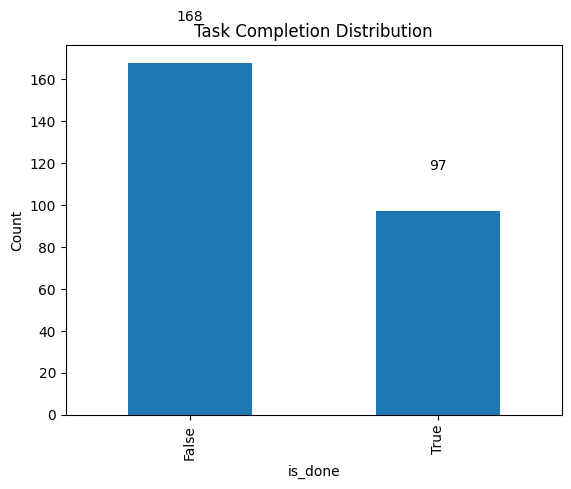

In [9]:
counts = combined_df["is_done"].value_counts()
print(f"Task Completion Rate: {combined_df['is_done'].mean() * 100:.1f}%")
counts.plot(kind="bar", title="Task Completion Distribution")
for i in range(len(counts)):
    plt.text(i, counts.iloc[i] + 20, counts.iloc[i], ha="center")
plt.xlabel("is_done")
plt.ylabel("Count")
plt.show()

*  We'll filter data set date range to start from the date of the first task completion to ensure we only model tasks that were created after the task completion feature was made available in the app.
* **First Task Created At:** `2024-11-08 07:26:26`
* **First Task Completed At:** `2025-01-15 13:30:37`

### Parent/Child Status

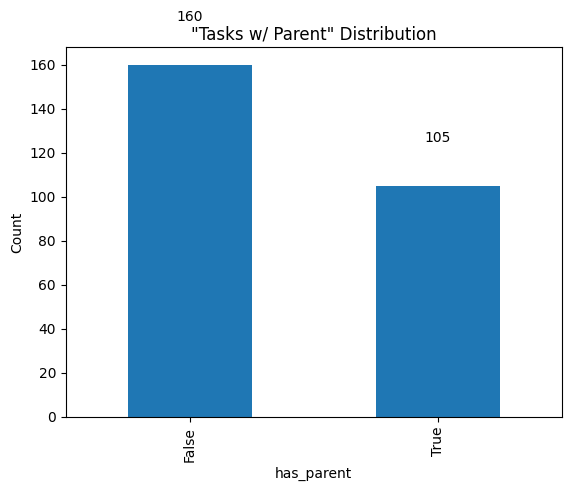

In [10]:
combined_df["has_parent"] = combined_df["parent_item_id"].notnull()
counts = combined_df["has_parent"].value_counts()
counts.plot(kind="bar", title='"Tasks w/ Parent" Distribution')
for i in range(len(counts)):
    plt.text(i, counts.iloc[i] + 20, counts.iloc[i], ha="center")
plt.xlabel("has_parent")
plt.ylabel("Count")
plt.show()

### Task Publicity

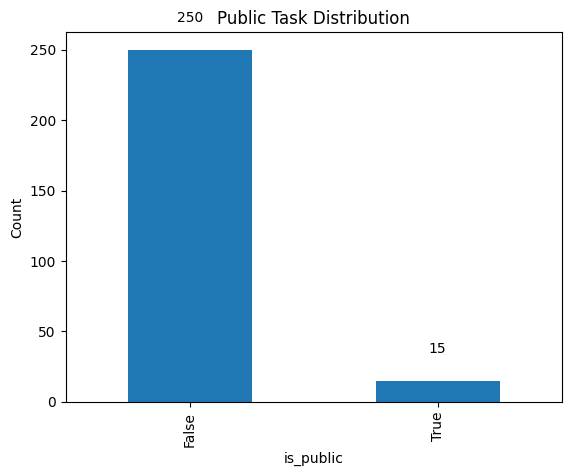

In [11]:
counts = combined_df["is_public"].value_counts()
counts.plot(kind="bar", title="Public Task Distribution")
for i in range(len(counts)):
    plt.text(i, counts.iloc[i] + 20, counts.iloc[i], ha="center")
plt.xlabel("is_public")
plt.ylabel("Count")
plt.show()

## Data Preparation

In [12]:
def prepare_data(tasks_df):
    """Prepare the data for modeling."""

    X = tasks_df.copy()

    # Ensure any boolean columns are converted to integers
    X["is_public"] = X["is_public"].astype(int)

    # Extract date and time features from 'createdAt'
    X["createdAt"] = pd.to_datetime(X["createdAt"])
    X["hour_of_day"] = X["createdAt"].dt.hour  # 24-hour format
    X["day_of_week"] = X["createdAt"].dt.dayofweek  # 0=Monday, 6=Sunday

    X["has_parent"] = X["parent_item_id"].notnull().astype(int)

    # Create topic similarity features using embeddings
    hf_token = os.getenv("HF_TOKEN")
    API_URL = "https://api-inference.huggingface.co/models/sentence-transformers/all-MiniLM-L6-v2"
    headers = {"Authorization": f"Bearer {hf_token}"}
    topic_list = [
        "Chores",
        "Play",
        "Work",
        "Errands",
        "Eating",
        "Friends",
        "Family",
        "Shopping",
        "Excercise",
    ]

    def get_topic_similarities(item_text, topics):
        response = requests.post(
            API_URL,
            headers=headers,
            json={
                "inputs": {"source_sentence": item_text, "sentences": topics},
            },
            timeout=60,
        )
        if response.status_code == 200:
            similarities = response.json()
            return {
                f"similarity_{topic}": similarities[i] for i, topic in enumerate(topics)
            }

        print(f"Failed to get embedding for '{item_text}'")
        print(f"Response Code: {response.status_code}, Response Text: {response.text}")
        return {f"similarity_{topic}": None for topic in topics}

    def add_similarity_features(df):
        similarity_dicts = []
        for text in tqdm(df["text"], desc="Calculating similarities"):
            similarity_features = get_topic_similarities(text, topic_list)
            similarity_dicts.append(similarity_features)

        similarity_df = pd.DataFrame(similarity_dicts)
        return pd.concat([df.reset_index(drop=True), similarity_df], axis=1)

    X = add_similarity_features(X)

    # Reduce df columns to only those needed for modeling
    numerical_cols = [
        "hour_of_day",
        "day_of_week",
        "has_parent",
        "is_public",
    ]
    topic_similarity_cols = [f"similarity_{topic}" for topic in topic_list]
    return X[numerical_cols + topic_similarity_cols]

In [13]:
X_train_prepared = prepare_data(X_train)

Calculating similarities: 100%|██████████| 265/265 [00:53<00:00,  4.96it/s]


## Model Training

In [14]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("dootoo_item_prediction")

2025/07/10 10:46:43 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/10 10:46:43 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/pt7481/dootoo_item_prediction/eda/mlruns/1', creation_time=1752087524231, experiment_id='1', last_update_time=1752087524231, lifecycle_stage='active', name='dootoo_item_prediction', tags={}>

In [15]:
def train_model(X, y):
    """Train the XGBoost model using tuned hyperparameters."""

    param_grid = {
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 200],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "reg_alpha": [0, 0.1, 1],  # L1 regularization
        "reg_lambda": [1, 1.5, 3],  # L2 regularization
    }

    xgbc = XGBClassifier(random_state=42, eval_metric="logloss")
    grid = GridSearchCV(
        xgbc, param_grid, cv=3, scoring="neg_log_loss", n_jobs=-1, verbose=1
    )
    grid.fit(X, y)

    print("Best params:", grid.best_params_)
    print("Best score:", grid.best_score_)
    xgbc = grid.best_estimator_

    return xgbc

In [16]:
def log_model_metrics(model, X, y, dataset_name="X_train"):
    """Log model metrics and parameters to MLflow."""
    with mlflow.start_run():
        mlflow.log_param("n_estimators", model.n_estimators)
        mlflow.log_param("max_depth", model.max_depth)
        mlflow.log_param("learning_rate", model.learning_rate)
        mlflow.log_param("random_state", model.random_state)

        mlflow.set_tag("dataset", dataset_name)

        # Obtain predictions of training data to evaluate model bias
        y_pred = model.predict(X)
        y_proba = model.predict_proba(X)

        log_loss_value = log_loss(y, y_proba)
        mlflow.log_metric("log_loss", log_loss_value)
        mlflow.log_metric("precision", precision_score(y, y_pred))
        mlflow.log_metric("recall", recall_score(y, y_pred))
        mlflow.log_metric("f1_score", f1_score(y, y_pred))
        mlflow.log_metric("accuracy", accuracy_score(y, y_pred))

        signature = infer_signature(X, y_pred)
        mlflow.xgboost.log_model(
            model,
            name="dootoo_item_prediction_model",
            signature=signature,
            input_example=X.sample(10),
        )

    print(classification_report(y, y_pred))

    conf_matrix = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrix, display_labels=model.classes_
    )
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    # Plot feature importances
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances.nlargest(10).plot(kind="barh")
    plt.title(f"Feature Importances - {dataset_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

    # Plot SHAP values
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, plot_type="dot", show=False)
    plt.title(f"SHAP Summary Plot - {dataset_name}")
    plt.show()

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 3, 'subsample': 1.0}
Best score: -0.6470825849415057


/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-k-eDdehA/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-k-eDdehA/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [10:47:21] WARNING: /workspace/src/c_api/c_api.cc:14

              precision    recall  f1-score   support

       False       0.67      0.99      0.80       168
        True       0.94      0.15      0.27        97

    accuracy                           0.69       265
   macro avg       0.80      0.57      0.53       265
weighted avg       0.77      0.69      0.60       265



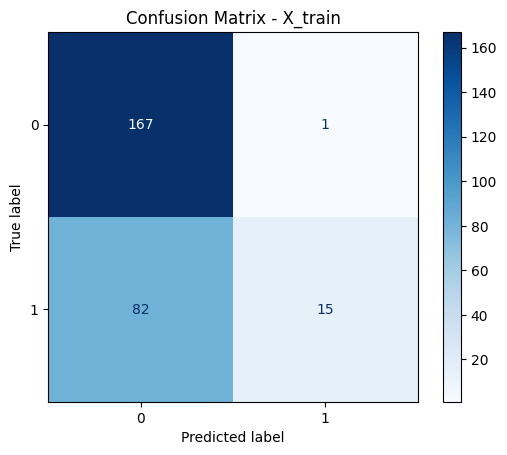

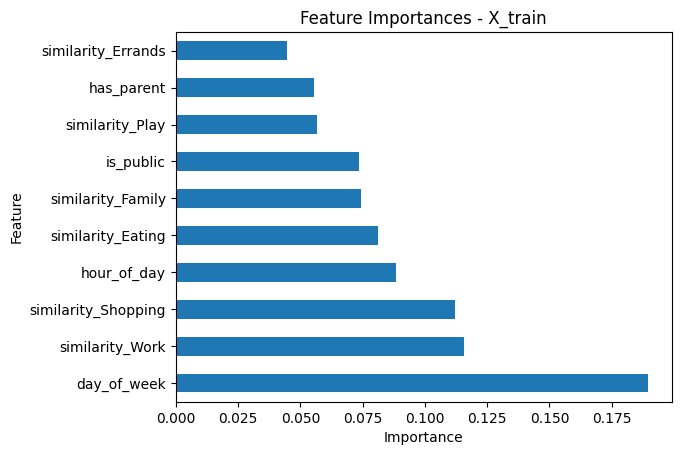

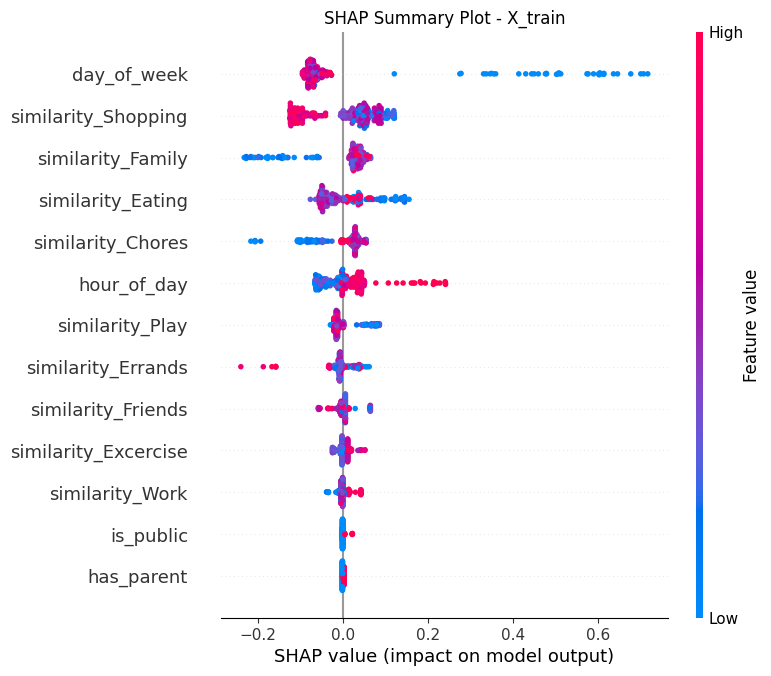

In [17]:
clf_all_features = train_model(X_train_prepared, y_train)
log_model_metrics(clf_all_features, X_train_prepared, y_train, dataset_name="X_train")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 3, 'subsample': 1.0}
Best score: -0.6069726959826456


/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-k-eDdehA/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-k-eDdehA/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [10:47:36] WARNING: /workspace/src/c_api/c_api.cc:14

              precision    recall  f1-score   support

       False       0.80      0.90      0.85       168
        True       0.78      0.60      0.68        97

    accuracy                           0.79       265
   macro avg       0.79      0.75      0.76       265
weighted avg       0.79      0.79      0.79       265



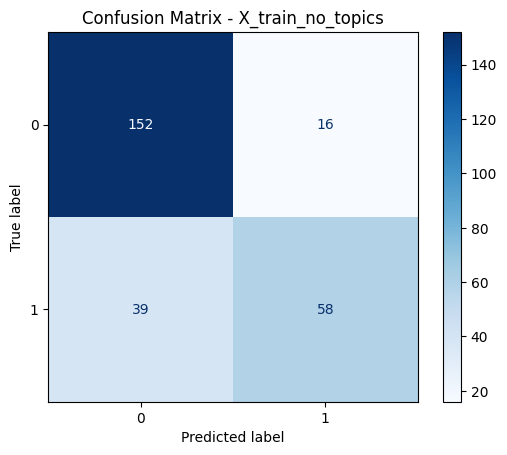

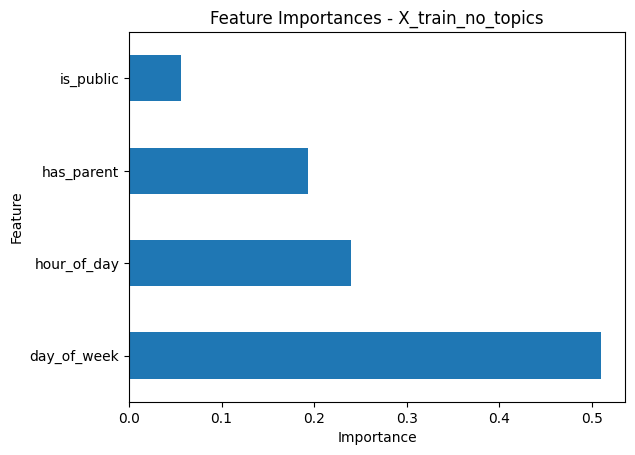

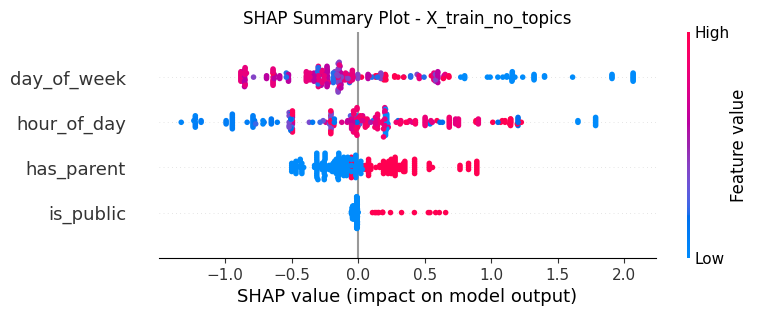

In [18]:
# Ablation testing: Remove topic similarity features and retrain
filtered_cols = [
    "hour_of_day",
    "day_of_week",
    "has_parent",
    "is_public",
]
X_train_prepared_no_topic = X_train_prepared[filtered_cols]
clf_no_topics = train_model(X_train_prepared_no_topic, y_train)
log_model_metrics(
    clf_no_topics, X_train_prepared_no_topic, y_train, dataset_name="X_train_no_topics"
)

Calculating similarities: 100%|██████████| 67/67 [00:14<00:00,  4.76it/s]
/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-k-eDdehA/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-k-eDdehA/lib/python3.12/site-packages/xgboost/sklearn.

              precision    recall  f1-score   support

       False       0.68      0.98      0.80        43
        True       0.80      0.17      0.28        24

    accuracy                           0.69        67
   macro avg       0.74      0.57      0.54        67
weighted avg       0.72      0.69      0.61        67



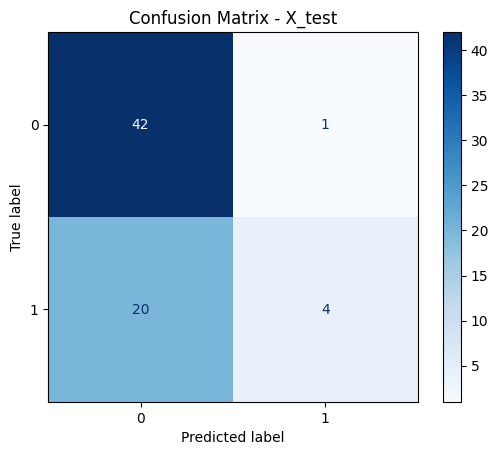

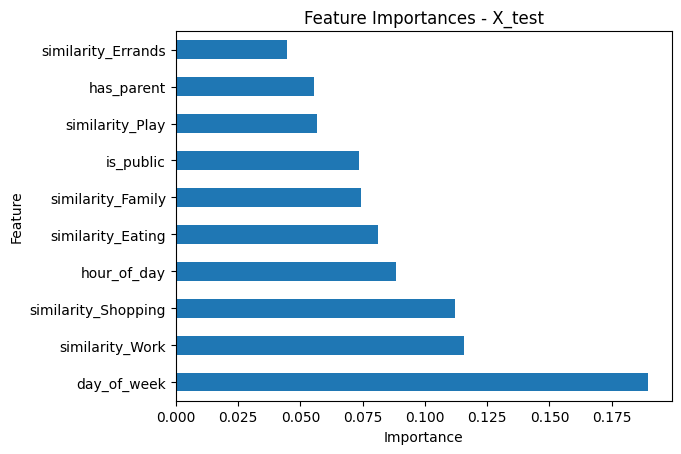

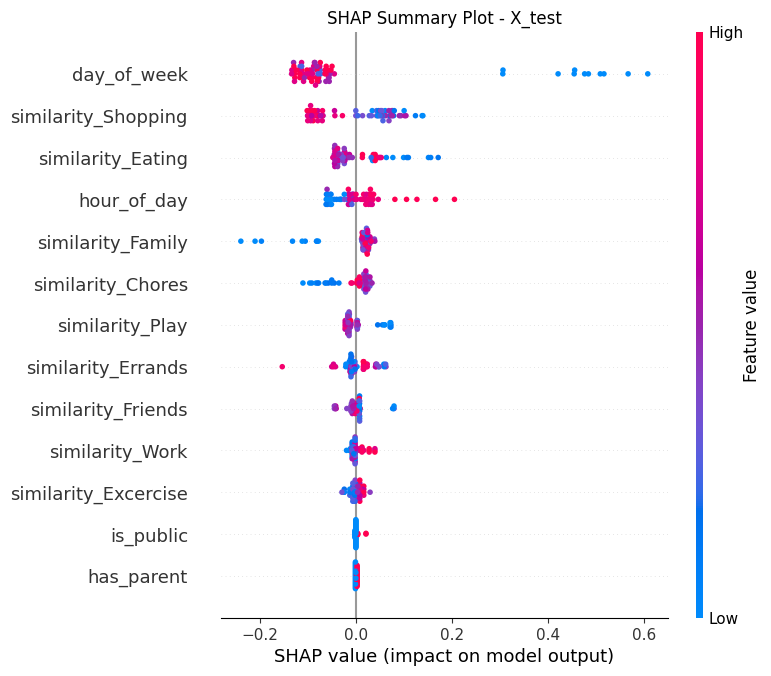

In [19]:
X_test_prepared = prepare_data(X_test)
log_model_metrics(clf_all_features, X_test_prepared, y_test, dataset_name="X_test")

/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-k-eDdehA/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/pt7481/.local/share/virtualenvs/dootoo_item_prediction-k-eDdehA/lib/python3.12/site-packages/xgboost/sklearn.py:1028: UserWarning: [10:47:59] WARNING: /workspace/src/c_api/c_api.cc:14

              precision    recall  f1-score   support

       False       0.71      0.81      0.76        43
        True       0.56      0.42      0.48        24

    accuracy                           0.67        67
   macro avg       0.63      0.62      0.62        67
weighted avg       0.66      0.67      0.66        67



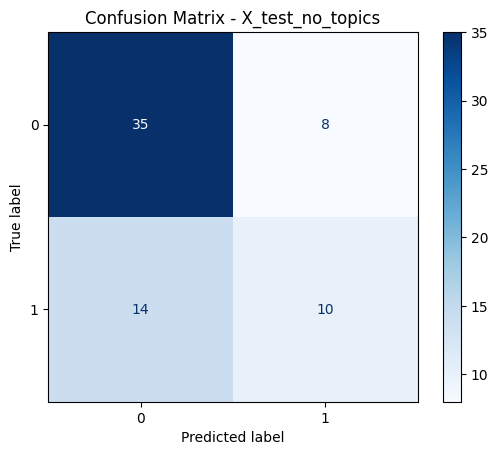

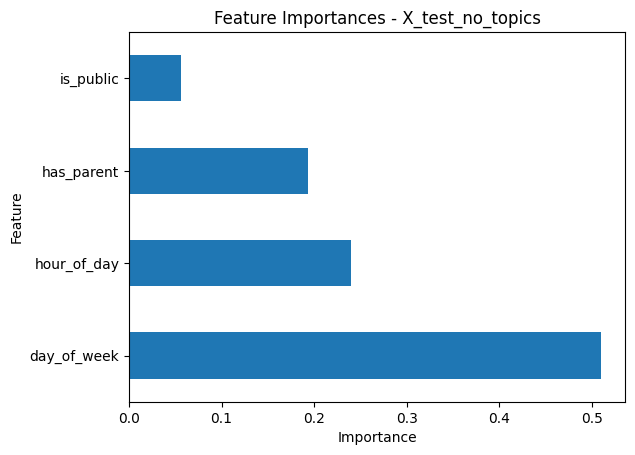

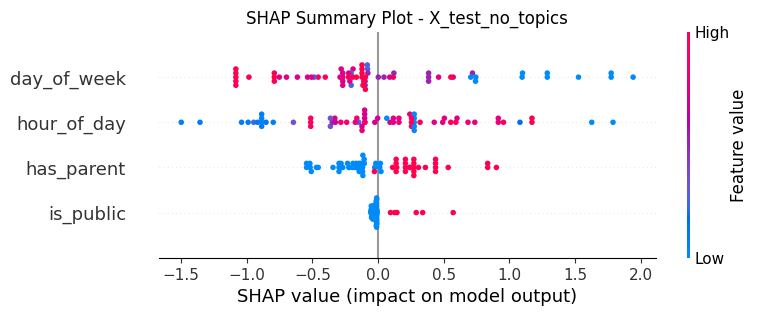

In [20]:
X_test_prepared_no_topic = X_test_prepared[filtered_cols]
log_model_metrics(
    clf_no_topics, X_test_prepared_no_topic, y_test, dataset_name="X_test_no_topics"
)

------

In [22]:
def slugify(text):
    text = text.strip()
    text = re.sub(r"[^\w\s\-]", "", text)  # allow (), - and alphanumerics
    return re.sub(r"[\s]+", "-", text)


def extract_headings(ipynb_path):
    with open(ipynb_path, "r", encoding="utf-8") as f:
        nb = json.load(f)

    toc_lines = []  # ["## Table of Contents\n"]
    for cell in nb["cells"]:
        if cell["cell_type"] == "markdown":
            for line in cell["source"]:
                match = re.match(r"^(#{2,6})\s+(.*)", line)
                if match:
                    level = len(match.group(1)) - 1  # offset for nesting
                    title = match.group(2).strip()
                    anchor = slugify(title)
                    indent = "    " * (level - 1)
                    toc_lines.append(f"{indent}1. [{title}](#{anchor})")

    return "\n".join(toc_lines)


# Example usage:
TOC = extract_headings("dootoo_item_prediction.ipynb")
print(TOC)

1. [Table of Contents](#Table-of-Contents)
1. [Project Summary](#Project-Summary)
    1. [What I Did](#What-I-Did)
    1. [What I Learned](#What-I-Learned)
    1. [Next Steps](#Next-Steps)
1. [Source Data](#Source-Data)
    1. [Data Set Creation](#Data-Set-Creation)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    1. [Target Analysis ("is_done")](#Target-Analysis-is_done)
    1. [Parent/Child Status](#ParentChild-Status)
    1. [Task Publicity](#Task-Publicity)
1. [Data Preparation](#Data-Preparation)
1. [Model Training](#Model-Training)
